In [1]:
import cv2
import os

data_path = "C:/Users/CHANDRU/Desktop/Computer vision/dataset"
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:',e)


In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [4]:
np.save('data',data)
np.save('target',new_target)

In [5]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [6]:

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 53s 54ms/step - loss: 0.7175 - accuracy: 0.5626 - val_loss: 0.6118 - val_accuracy: 0.6290
Epoch 2/20
990/990 [==============================] - 53s 53ms/step - loss: 0.6132 - accuracy: 0.6394 - val_loss: 0.4739 - val_accuracy: 0.8024
Epoch 3/20
990/990 [==============================] - 51s 52ms/step - loss: 0.4534 - accuracy: 0.7980 - val_loss: 0.3051 - val_accuracy: 0.8871
Epoch 4/20
990/990 [==============================] - 53s 53ms/step - loss: 0.3447 - accuracy: 0.8667 - val_loss: 0.2924 - val_accuracy: 0.8790
Epoch 5/20
990/990 [==============================] - 50s 51ms/step - loss: 0.2345 - accuracy: 0.9212 - val_loss: 0.1962 - val_accuracy: 0.9395
Epoch 6/20
990/990 [==============================] - 52s 52ms/step - loss: 0.2352 - accuracy: 0.9101 - val_loss: 0.1613 - val_accuracy: 0.9435
Epoch 7/20
990/990 [==============================] - 53s 54ms/step - loss: 0.1765 - accur

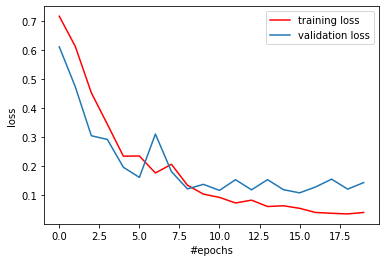

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
print(model.evaluate(test_data,test_target))

138/138 [==============================] - 2s 15ms/step
[0.05851276197295258, 0.97826087474823]


In [11]:
from keras.models import load_model
import cv2
import numpy as np

In [41]:
model = load_model('C:/Users/CHANDRU/Desktop/Computer vision/model-017.model')

face_clsfr=cv2.CascadeClassifier('C:/Users/CHANDRU/Desktop/Computer vision/haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [42]:
while(True):

    _, img=source.read()
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result)
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cv2.destroyAllWindows()
source.release()